<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-This-Notebook-takes-all-steps-from-loading-data-&amp;-packages-to-creating-a-submission-.csv-file-" data-toc-modified-id="-This-Notebook-takes-all-steps-from-loading-data-&amp;-packages-to-creating-a-submission-.csv-file--1"><span class="toc-item-num">1&nbsp;&nbsp;</span> This Notebook takes all steps from loading data &amp; packages to creating a submission .csv file </a></span><ul class="toc-item"><li><span><a href="#-1-|-Packages-" data-toc-modified-id="-1-|-Packages--1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span> 1 | Packages </a></span></li><li><span><a href="#-2-|-Configuration-" data-toc-modified-id="-2-|-Configuration--1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span> 2 | Configuration </a></span></li><li><span><a href="#-3-|-Load-Data-" data-toc-modified-id="-3-|-Load-Data--1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span> 3 | Load Data </a></span></li><li><span><a href="#-4-|-Prepare-Data-" data-toc-modified-id="-4-|-Prepare-Data--1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span> 4 | Prepare Data </a></span></li><li><span><a href="#-5-|-Fit-RandomForestRegressor-" data-toc-modified-id="-5-|-Fit-RandomForestRegressor--1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span> 5 | Fit RandomForestRegressor </a></span></li><li><span><a href="#-6-|-Evaluate-" data-toc-modified-id="-6-|-Evaluate--1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span> 6 | Evaluate </a></span></li><li><span><a href="#-7-|-Predict-and-Make-Submission-File-" data-toc-modified-id="-7-|-Predict-and-Make-Submission-File--1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span> 7 | Predict and Make Submission File </a></span></li></ul></li></ul></div>

<h1> This Notebook takes all steps from loading data & packages to creating a submission .csv file </h1>
<p>The goal here is to show a basic example script that runs reasonably fast. Therefore, certain columns are eliminated and the RandomForest is fitted with a relatively low number of estimators </p>
<ol>
<li> Packages are imported</li>
<li> Configuration is set </li>
<li> Data is loaded </li>
<li> Data is prepared for model  </li>
<li> RandomForestRegressor is trained </li>
<li> Results are evaluated </li>
<li> Prediction submission file is made </li>
</ol>

<h2> 1 | Packages </h2>

In [2]:
import pandas as pd
import numpy as np
import os
import re
import random
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

<h2> 2 | Configuration </h2>

In [3]:
random.seed(3)  #To make the randomization reproducible
pd.options.mode.chained_assignment = None  #To turn off specific warnings

<h2> 3 | Load Data </h2>


In [4]:
train = pd.read_csv(r"./data/train_2016_v2.csv")   #The parcelid's with their outcomes
props = pd.read_csv(r"./data/properties_2016.csv")  #The properties dataset
samp = pd.read_csv(r"./data/sample_submission.csv")  #The parcelid's for the testset

/Users/billyu/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
props.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


<h2> 4 | Prepare Data </h2>

In [4]:
props = props.select_dtypes(exclude=[object])  #For this example, we take only numerical data, since strings require more processing
props.fillna(-1,inplace=True)  #Fill missing data so we can run the model

train = train.loc[:,['parcelid','logerror']].merge(props,how='left',left_on='parcelid',right_on='parcelid')
train_x = train.drop(['parcelid','logerror'],axis=1,inplace=False)
train_y = train['logerror']

test = samp.loc[:,['ParcelId']].merge(props,how='left',left_on='ParcelId',right_on='parcelid')
test_x = test.drop(['ParcelId','parcelid'],axis=1,inplace=False)

<h2> 5 | Fit RandomForestRegressor </h2>

In [5]:
parameters = {'n_estimators':[5,10,15],'n_jobs':[-1],'oob_score':[False]}  # this can be extended
model = RandomForestRegressor()
grid = GridSearchCV(model,param_grid=parameters,scoring='neg_mean_absolute_error',cv=3)  
grid.fit(train_x,train_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 15], 'n_jobs': [-1], 'oob_score': [False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_absolute_error', verbose=0)

<h2> 6 | Evaluate </h2>
<p> We can see the test scores in the crossvalidation table. Also, we see the 20 most important features in a column chart. </p>

  param_n_estimators  mean_test_score  std_test_score
0                  5        -0.089714        0.001847
1                 10        -0.083073        0.002677
2                 15        -0.080304        0.002533


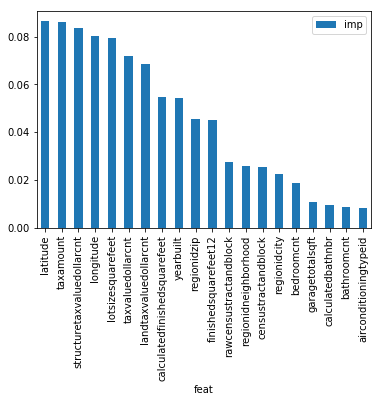

In [6]:
cv_results = pd.DataFrame(grid.cv_results_)
print(cv_results[["param_n_estimators","mean_test_score","std_test_score"]])

feat_imps = grid.best_estimator_.feature_importances_
fi = pd.DataFrame.from_dict({'feat':train_x.columns,'imp':feat_imps})
fi.set_index('feat',inplace=True,drop=True)
fi = fi.sort_values('imp',ascending=False)
fi.head(20).plot.bar()

<h2> 7 | Predict and Make Submission File </h2>
<p> The submission file is prepared with a datetime stamp so that it is not overwrited by consecutive submission files and it remains clear when the submission file was generated. For now, we assume the result is the same fot each month. </p>

In [7]:
test_y = grid.predict(test_x)
test_y = pd.DataFrame(test_y)
test_y[1] = test_y[0]
test_y[2] = test_y[0]
test_y[3] = test_y[0]
test_y[4] = test_y[0]
test_y[5] = test_y[0]  #For simplicity make identical predictions for all months
test_y.columns = ["201610","201611","201612","201710","201711","201712"]
submission = test_y.copy()
submission["parcelid"] = samp["ParcelId"].copy()
cols = ["parcelid","201610","201611","201612","201710","201711","201712"]
submission = submission[cols]
filename = "Prediction_" + str(submission.columns[0]) + re.sub("[^0-9]", "",str(datetime.datetime.now())) + '.csv'
print(filename)
submission.to_csv(filename,index=False)


Prediction_parcelid20170705211153323514.csv
